In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data_csv = pd.read_csv('../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')
print(data_csv['age'].unique()) #1~116
print(data_csv['ethnicity'].unique()) #0~4
data_csv.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv'

In [77]:
def age_cvt(age) :
    return int(age/10)

data_csv['age'] = data_csv['age'].apply(lambda x : age_cvt(x))
data_csv.head()

,age,ethnicity,gender,img_name,pixels
0,0,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,0,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,0,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,0,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,0,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


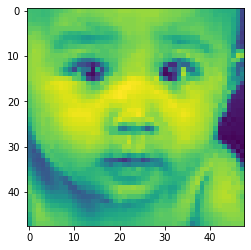

In [78]:
import matplotlib.pyplot as plt

data_csv['pixels'] = data_csv['pixels'].apply(lambda x : np.array(x.split(), dtype="float32"))
data_csv['pixels'] = data_csv['pixels'] / 255.0

plt.imshow(data_csv['pixels'][0].reshape(48, 48)) #2304 = 48*48
plt.show()

In [79]:
test_list = [4, 504, 1004, 2504, 5004, 6904, 17894, 18644, 20004, 23014]

print(len(data_csv))

test_csv = pd.DataFrame()
for i in test_list :
    test_csv = test_csv.append(data_csv.iloc[i])
    data_csv = data_csv.drop(i)

print(len(data_csv))
test_csv.head()

23705
23695


,age,ethnicity,gender,img_name,pixels
4,0.0,2.0,0.0,20161220144914327.jpg.chip.jpg,"[0.7921569, 0.8039216, 0.81960785, 0.8235294, ..."
505,0.0,2.0,0.0,20161219161941534.jpg.chip.jpg,"[0.8117647, 0.8117647, 0.8039216, 0.8, 0.78823..."
1006,0.0,2.0,1.0,20161219162225422.jpg.chip.jpg,"[0.0, 0.003921569, 0.0, 0.003921569, 0.0431372..."
2507,1.0,0.0,1.0,20170109213935367.jpg.chip.jpg,"[0.1254902, 0.12156863, 0.14117648, 0.11372549..."
5008,2.0,1.0,0.0,20170102233456210.jpg.chip.jpg,"[0.6666667, 0.62352943, 0.5568628, 0.6392157, ..."


In [80]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import cv2

class dataset(Dataset) :
    def __init__(self, age_label, eth_label, gen_label, img) :
        self.age_label = np.array(age_label)
        self.eth_label = np.array(eth_label)
        self.gen_label = np.array(gen_label)
        self.img = np.array(img)
        
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
        
    def __len__(self) :
        return len(self.img)
    
    def __getitem__(self, index) :
        age_label = self.age_label[index]
        eth_label = self.eth_label[index]
        gen_label = self.gen_label[index]
        
        img = self.img[index].reshape(48, 48, 1)
        #img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        img = self.transform(img)
        
        return img, age_label, eth_label, gen_label
    
train_data = dataset(data_csv['age'][:], data_csv['ethnicity'][:], 
                     data_csv['gender'][:], data_csv['pixels'][:])
train_data = DataLoader(train_data, batch_size = 128, shuffle = True)

In [81]:
age_features = len(data_csv['age'].unique())
eth_features = len(data_csv['ethnicity'].unique())
gen_features = len(data_csv['gender'].unique())

print(age_features, eth_features, gen_features)

12 5 2


In [7]:
!pip install timm

     |████████████████████████████████| 287 kB 1.2 MB/s eta 0:00:01


In [15]:
!pip install torchsummary

In [87]:
import torch.nn as nn
import timm
from timm.models.layers.classifier import ClassifierHead
from torchsummary import summary

class MultiLabelCNN(nn.Module) :
    def __init__(self, age_features, ethnicity_features, gender_features) :
        super().__init__()   
        '''
        self.model = timm.create_model('dm_nfnet_f0', pretrained = False)
        n_features = self.model.num_features
        self.age_classifier = ClassifierHead(n_features, age_features)
        self.eth_classifier = ClassifierHead(n_features, ethnicity_features)
        self.gen_classifier = ClassifierHead(n_features, gender_features)
        '''
        self.cnnModel = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #24
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #12
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #6
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #3
            #nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)) #flatten
        )
        
        self.dnnModel = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
        )
        
        self.age_classifier = nn.Linear(32, age_features)
        self.eth_classifier = nn.Linear(32, ethnicity_features)
        self.gen_classifier = nn.Linear(32, gender_features)     
    def forward(self, x) :
        '''
        output = self.model.forward_features(x)
        age = self.age_classifier(output)
        eth = self.eth_classifier(output)
        gen = self.gen_classifier(output)
        '''
        output = self.cnnModel(x)
        output = output.squeeze()
        output = self.dnnModel(output)
        
        age = self.age_classifier(output)
        eth = self.eth_classifier(output)
        gen = self.gen_classifier(output)
        return age, eth, gen
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelCNN(age_features, eth_features, gen_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

def custom_loss (output, target) :
    age_loss = nn.CrossEntropyLoss().to(device)(output[0], target[0])
    eth_loss =  nn.CrossEntropyLoss().to(device)(output[1], target[1])
    gen_loss =  nn.CrossEntropyLoss().to(device)(output[2], target[2])
    
    return age_loss + eth_loss + gen_loss, age_loss.item(), eth_loss.item(), gen_loss.item()

summary(model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
         MaxPool2d-2           [-1, 32, 24, 24]               0
         LeakyReLU-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          18,496
         MaxPool2d-5           [-1, 64, 12, 12]               0
         LeakyReLU-6           [-1, 64, 12, 12]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
         MaxPool2d-8            [-1, 128, 6, 6]               0
         LeakyReLU-9            [-1, 128, 6, 6]               0
           Conv2d-10            [-1, 256, 6, 6]         295,168
        MaxPool2d-11            [-1, 256, 3, 3]               0
AdaptiveAvgPool2d-12            [-1, 256, 1, 1]               0
           Linear-13                  [-1, 128]          32,896
        LeakyReLU-14                  [

In [88]:
from tqdm.notebook import tqdm

epoch_num = 100
model.train()

for epoch in range(epoch_num) :
    epoch_loss = 0
    epoch_acc = 0
    for img, age, eth, gen in tqdm(train_data) :
        img = img.to(device)
        age = age.to(device)
        eth = eth.to(device)
        gen = gen.to(device)
        
        predict = model(img)
        
        loss = custom_loss(predict, (age, eth, gen))
        
        optimizer.zero_grad()
        loss[0].backward()
        optimizer.step()
        
        correct_prediction = 0
        for i, _ in enumerate(age) :
            if torch.argmax(predict[0][i]) == age[i] and \
            torch.argmax(predict[1][i]) == eth[i] and \
            torch.argmax(predict[2][i]) == gen[i] :
                correct_prediction += 1
                
        epoch_loss += loss[0]
        epoch_acc += correct_prediction / img.shape[0]
        
    epoch_loss = epoch_loss / len(train_data)
    epoch_acc = epoch_acc / len(train_data)
    print('Epoch : {}/{},   loss : {:.5f},    acc : {:.5f}'.format(epoch+1, epoch_num, epoch_loss, epoch_acc))
    
    if epoch_acc > 0.93 and epoch_loss < 0.2 :
        print('early stop')
        break

  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 1/100,   loss : 4.13226,    acc : 0.04267


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 2/100,   loss : 3.80407,    acc : 0.08073


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 3/100,   loss : 3.44384,    acc : 0.13023


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 4/100,   loss : 3.04605,    acc : 0.18336


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 5/100,   loss : 2.75870,    acc : 0.22697


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 6/100,   loss : 2.58016,    acc : 0.25778


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 7/100,   loss : 2.43657,    acc : 0.28384


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 8/100,   loss : 2.30761,    acc : 0.31104


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 9/100,   loss : 2.20707,    acc : 0.32736


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 10/100,   loss : 2.17147,    acc : 0.33105


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 11/100,   loss : 2.08393,    acc : 0.34691


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 12/100,   loss : 2.02603,    acc : 0.36148


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 13/100,   loss : 1.95513,    acc : 0.37562


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 14/100,   loss : 1.90475,    acc : 0.38970


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 15/100,   loss : 1.86289,    acc : 0.39183


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 16/100,   loss : 1.81248,    acc : 0.40264


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 17/100,   loss : 1.76150,    acc : 0.41756


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 18/100,   loss : 1.74190,    acc : 0.42207


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 19/100,   loss : 1.68231,    acc : 0.43445


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 20/100,   loss : 1.65036,    acc : 0.44356


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 21/100,   loss : 1.60395,    acc : 0.45505


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 22/100,   loss : 1.55115,    acc : 0.46746


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 23/100,   loss : 1.51882,    acc : 0.47685


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 24/100,   loss : 1.47214,    acc : 0.49205


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 25/100,   loss : 1.43853,    acc : 0.49783


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 26/100,   loss : 1.38850,    acc : 0.51551


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 27/100,   loss : 1.36777,    acc : 0.51902


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 28/100,   loss : 1.29888,    acc : 0.53603


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 29/100,   loss : 1.26713,    acc : 0.54510


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 30/100,   loss : 1.24306,    acc : 0.55543


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 31/100,   loss : 1.19897,    acc : 0.56574


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 32/100,   loss : 1.15717,    acc : 0.57478


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 33/100,   loss : 1.12359,    acc : 0.59089


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 34/100,   loss : 1.05414,    acc : 0.60792


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 35/100,   loss : 1.02508,    acc : 0.62270


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 36/100,   loss : 0.97912,    acc : 0.63938


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 37/100,   loss : 0.97968,    acc : 0.63915


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 38/100,   loss : 0.94759,    acc : 0.64824


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 39/100,   loss : 0.89287,    acc : 0.66695


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 40/100,   loss : 0.84034,    acc : 0.68304


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 41/100,   loss : 0.85632,    acc : 0.68335


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 42/100,   loss : 0.79379,    acc : 0.70131


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 43/100,   loss : 0.74406,    acc : 0.72217


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 44/100,   loss : 0.72254,    acc : 0.72651


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 45/100,   loss : 0.66665,    acc : 0.74796


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 46/100,   loss : 0.65420,    acc : 0.75430


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 47/100,   loss : 0.64260,    acc : 0.76228


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 48/100,   loss : 0.64638,    acc : 0.75787


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 49/100,   loss : 0.57607,    acc : 0.78595


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 50/100,   loss : 0.51823,    acc : 0.80695


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 51/100,   loss : 0.54634,    acc : 0.79836


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 52/100,   loss : 0.50193,    acc : 0.81271


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 53/100,   loss : 0.46358,    acc : 0.83047


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 54/100,   loss : 0.47983,    acc : 0.82086


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 55/100,   loss : 0.49200,    acc : 0.81837


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 56/100,   loss : 0.43071,    acc : 0.84054


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 57/100,   loss : 0.36076,    acc : 0.87012


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 58/100,   loss : 0.42349,    acc : 0.84534


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 59/100,   loss : 0.37732,    acc : 0.86553


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 60/100,   loss : 0.37139,    acc : 0.86589


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 61/100,   loss : 0.37166,    acc : 0.86700


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 62/100,   loss : 0.34541,    acc : 0.87676


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 63/100,   loss : 0.32710,    acc : 0.88161


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 64/100,   loss : 0.36193,    acc : 0.87101


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 65/100,   loss : 0.32898,    acc : 0.88210


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 66/100,   loss : 0.32631,    acc : 0.88241


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 67/100,   loss : 0.32149,    acc : 0.88497


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 68/100,   loss : 0.26465,    acc : 0.91099


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 69/100,   loss : 0.33676,    acc : 0.88069


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 70/100,   loss : 0.22971,    acc : 0.92040


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 71/100,   loss : 0.25250,    acc : 0.91183


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 72/100,   loss : 0.26923,    acc : 0.90648


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 73/100,   loss : 0.26649,    acc : 0.90906


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 74/100,   loss : 0.23694,    acc : 0.91866


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 75/100,   loss : 0.24803,    acc : 0.91501


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 76/100,   loss : 0.26698,    acc : 0.90612


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 77/100,   loss : 0.27462,    acc : 0.90646


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 78/100,   loss : 0.22086,    acc : 0.92481


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 79/100,   loss : 0.28348,    acc : 0.90226


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 80/100,   loss : 0.20033,    acc : 0.93397


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 81/100,   loss : 0.22324,    acc : 0.92364


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 82/100,   loss : 0.23627,    acc : 0.91904


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 83/100,   loss : 0.26350,    acc : 0.90724


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 84/100,   loss : 0.21689,    acc : 0.92601


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 85/100,   loss : 0.20959,    acc : 0.92912


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 86/100,   loss : 0.25764,    acc : 0.90982


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 87/100,   loss : 0.17206,    acc : 0.94388


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 88/100,   loss : 0.21446,    acc : 0.92948


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 89/100,   loss : 0.19337,    acc : 0.93393


  0%|          | 0/186 [00:00<?, ?it/s]

Epoch : 90/100,   loss : 0.15673,    acc : 0.95056
early stop


10


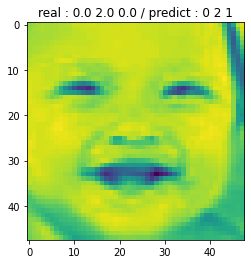

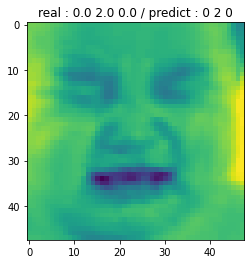

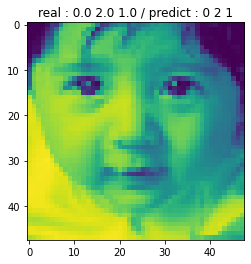

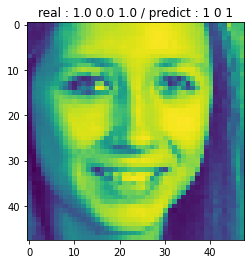

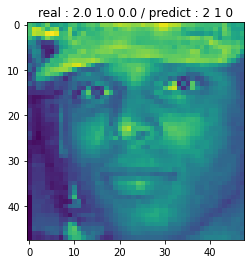

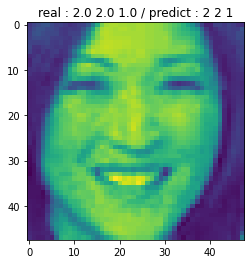

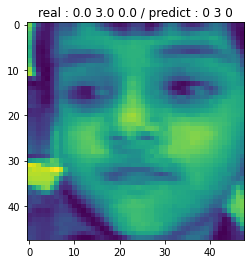

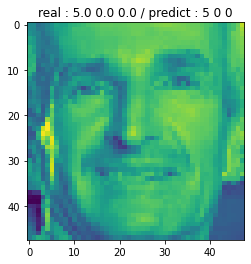

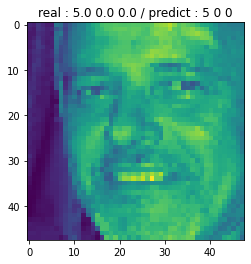

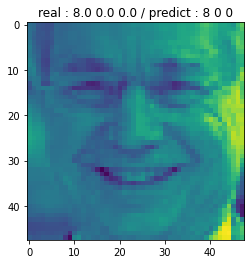

total_acc :  0.9


In [93]:
model.eval()

test_data = dataset(test_csv['age'][:], test_csv['ethnicity'][:], \
                     test_csv['gender'][:], test_csv['pixels'][:])
test_data = DataLoader(test_data, batch_size = 1, shuffle = False)
print(len(test_data))

correct_prediction = 0
for img, age, eth, gen in test_data :
    img = img.to(device)
    age = age.to(device)
    eth = eth.to(device)
    gen = gen.to(device)
    
    predict = model(img)
    
    real = str(age[0].item()) + ' ' + str(eth[0].item()) + ' ' + str(gen[0].item())
    pred = str(torch.argmax(predict[0]).item()) + ' ' + \
    str(torch.argmax(predict[1]).item()) + ' ' + str(torch.argmax(predict[2]).item())
    
    img = img.reshape(1, 48, 48).to('cpu').numpy()
    plt.imshow(img.transpose(1, 2, 0))
    plt.title('real : ' + str(real) + ' / predict : ' + str(pred))
    plt.show()
    
    if age[0] == torch.argmax(predict[0]) and \
    eth[0] == torch.argmax(predict[1]) and \
    gen[0] == torch.argmax(predict[2]) : correct_prediction += 1

print('total_acc : ', str(correct_prediction / len(test_data)))